## 🎭 Disney Audition Search Agent — Height-Aware, Performer-Focused Audition Discovery

Disney auditions include strict height ranges, performer-presentation requirements, and union classifications, yet the official audition website cannot be filtered by height, gender-presentation, or Equity status. Performers must manually filter through all global audition listings (on a website that is not mobile-friendly), interpret inconsistent height formats (some in inches, some listed in cm), and risk missing roles they are qualified for when auditions appear and disappear in a matter of days.

This project builds a Concierge-style multi-agent system that converts the raw Disney audition feed into a structured, height-queryable database and supporting natural language queries such as:

    
> “I’m a 5'4" dancer,  what can I audition for?”

> “How many equity roles are open?”

> "How many male-presenting auditions are open in Asia?"

> "My friends describe me as high-energy - what roles might best fit my personality?"
    


🚀 What the Agent Does

Fetches and preprocesses the latest audition feed (XML/HTML → structured dataframe)

Normalizes height ranges (feet/inches ↔ centimeters)

Summarizes open auditions with job ID included

Supports semantic queries with nuanced interests.


🧠 System Architecture

A sequential multi-agent pipeline:

Locale Agent — determines units, region, and language

Data Agent — fetches, cleans, normalizes, and structures the audition data

Summarizer Agent — interprets user queries and applies semantic + structured filtering

🔑 Key Concepts Demonstrated

Multi-agent orchestration (sequential pipeline)

Custom tools for data cleaning, height conversion, and feed retrieval

Agent-as-a-Tool (A2A)

Context-efficient preprocessing

Gemini models for semantic understanding

In [13]:
import os
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ Google API Key Setup and authentication complete.")
except Exception as e:
    print(
        f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )

✅ Google API Key Setup and authentication complete.


In [14]:
from google.adk.agents import Agent
from google.adk.runners import InMemoryRunner
from google.adk.tools import google_search, AgentTool
from google.genai import types
from google.adk.tools import FunctionTool

print("✅ ADK components imported successfully.")

✅ ADK components imported successfully.


Locale Handling:
The system defaults to English language and imperial units (feet/inches) to maintain consistent behavior across all environments. IP-based locale detection was intentionally omitted to preserve notebook portability and avoid external dependencies. However, the Locale Agent fully supports alternate languages and unit systems (e.g., French + centimeters) for testing or future extension. Several international audition listings were observed to include metric height requirements and multilingual descriptions, making extensible locale handling an important design consideration.

In [15]:
from datetime import date, datetime
from typing import Literal

def get_local_info() -> tuple[str, Literal["English"], Literal["in", "cm"]]:
    """Get current context information for the user's locale, including date, time, default language, and default unit of measurement.
    
    Returns:
        tuple: A 3-element tuple containing:
            - str: Current date and time in ISO 8601 format (e.g., "2025-11-29T14:30:45.123456")
            - Literal["English"]: The user's preferred language
            - Literal["in", "cm"]: Preferred unit system ("in" for imperial, "cm" for metric)
    
    Example:
        >>> get_local_info()
        ("2025-11-29T14:30:45.123456", "English", "in")
    """
    return datetime.now().isoformat(), "English", "in"

get_local_info()

('2025-12-01T16:30:01.136782', 'English', 'in')

In [16]:
locale_agent = Agent(
    name="locale_agent",
    model="gemini-2.5-flash-lite",
    description="Provides user locale preferences including datetime, language, and unit system",
    instruction="""You are a locale agent that provides regional preference information to other agents.
    You MUST use the get_local_info tool.

    Return a single JSON-formatted object with this exact structure:
    {
        "datetime": "value from get_local_info",
        "language": "default language code (e.g., 'en-US')",
        "unit_system": "imperial or metric"
    }
    
    """,
    tools=[get_local_info],
    output_key="local_preferences" # Single string key for the entire JSON output
)

print("✅ Locale Agent defined with structured JSON output.")

✅ Locale Agent defined with structured JSON output.


How Performers Normally Search

Disney’s audition site (jobs.disneycareers.com/auditions) only lets users filter by audition type, park, or city. Performers must manually scan each posting because you cannot filter by height range, gender-presenting roles, or Equity status. Some listings also appear in other languages with mixed units (cm vs. ft/in).

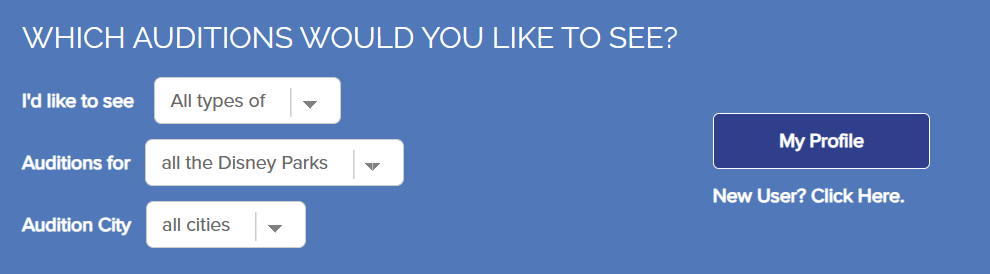

Why a Custom Tool Was Needed

UI automation and built-in search tools couldn’t reliably return all auditions.  I eventually found that the site loads every active audition at once from a backend feed:

https://services2.tmpwebeng.com/feed/disney-event-feed-proxy.aspx


This feed is semi-structured, inconsistent, and often includes:

multiple height ranges per role

different heights for different gender-presenting performers

mixed measurement units

What This Notebook Does Next

We fetch the full audition feed using a custom tool and preprocess it into a clean, structured dataframe for height-aware filtering and semantic querying. 






In [17]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

FEED_URL = "https://services2.tmpwebeng.com/feed/disney-event-feed-proxy.aspx"

def clean_html_description(html_text: str) -> str:
    """Clean HTML from job description and format as readable text"""
    if not html_text:
        return ""
    
    # Parse HTML
    soup = BeautifulSoup(html_text, 'html.parser')
    
    # Remove script and style elements
    for script in soup(["script", "style"]):
        script.decompose()
    
    # Get text and clean up whitespace
    text = soup.get_text(separator='\n')
    
    # Clean up excessive whitespace
    lines = [line.strip() for line in text.splitlines()]
    lines = [line for line in lines if line]  # Remove empty lines
    
    # Join with single newlines
    cleaned_text = '\n'.join(lines)
    
    # Remove excessive newlines (more than 2 in a row)
    cleaned_text = re.sub(r'\n{3,}', '\n\n', cleaned_text)
    
    return cleaned_text.strip()

def fetch_disney_auditions(save_to_file: bool = False, output_filename: str = "disney_auditions.csv"):
    """
    Fetch all current Disney audition listings from the official Disney casting feed.
    Returns list of auditions with details (ID, name, location, talent_type, dates, job_description).
    """
    total_auditions = 0
    r = requests.get(FEED_URL)
    r.raise_for_status()
    soup = BeautifulSoup(r.text, "xml")
    results = []
    
    for aud in soup.find_all("audition"):
        total_auditions += 1
        
        audition_id = aud.get("id", "")
        name = aud.find("name").text if aud.find("name") else ""
        businessunit = aud.find("businessunit").text if aud.find("businessunit") else ""
        city = aud.find("city").text if aud.find("city") else ""
        state = aud.find("state").text if aud.find("state") else ""
        venue = aud.find("venue").text if aud.find("venue") else ""
        talent = aud.find("talent_type").text if aud.find("talent_type") else ""
        start_date = aud.find("start_date").text if aud.find("start_date") else ""
        start_time = aud.find("start_time").text if aud.find("start_time") else ""
        timezone = aud.find("time_zone").text if aud.find("time_zone") else ""
        notes = aud.find("notes").text if aud.find("notes") else ""
        
        cleaned_description = clean_html_description(notes)
        
        results.append({
            "audition_id": audition_id,
            "name": name,
            "park_location": businessunit,
            "city": city,
            "state": state,
            "venue": venue,
            "talent_type": talent,
            "audition_date": start_date,
            "audition_time": start_time,
            "timezone": timezone,
            "job_description": cleaned_description,
        })
    
    if save_to_file and results:
        df = pd.DataFrame(results)
        df.to_csv(output_filename, index=False, encoding='utf-8')
        print(f"✓ Saved {len(results)} auditions to {output_filename}")
    
    return results, total_auditions

In [18]:
auditions, count = fetch_disney_auditions(save_to_file=False)
print(f"\nFOUND: {count} active Disney auditions\n")

for audition in auditions[:3]:
    print("─" * 60)
    print(f"Audition ID: {audition['audition_id']}")
    print(f"Name: {audition['name']}")
    print(f"Type: {audition['talent_type']}")
    print(f"Location: {audition['city']}, {audition['state']}")
    print(f"Audition Date/Deadline: {audition['audition_date']} at {audition['audition_time']}")
    print(f"Description: {audition['job_description'][:1000]}...")
    print()


FOUND: 49 active Disney auditions

────────────────────────────────────────────────────────────
Audition ID: 15983
Name: Submissions for TROMBONE Musicians for a New Show in Disneyland Park
Type: Musicians
Location: Anaheim, CA
Audition Date/Deadline: Sunday, November 30, 2025 at 12:00 PM
Description: Disney Live Entertainment is accepting submissions from TROMBONE Musician's for a new show coming to Disneyland Park.
SEEKING:
Seeking vibrant, energetic, and engaging Musicians from a diverse spectrum of musical and cultural backgrounds to join our dynamic ensemble. Ideal candidates should be friendly and comfortable engaging with children, especially in live performance. Strong musical improvisational skills and the ability to connect with young audiences are key.
ROLE:
Trombone:
Candidate must be a skilled tenor trombonist. The candidate must have strong tone, intonation, and rhythmic precision. The candidate must be comfortable performing in a variety of music styles including but no

In [19]:
import re

def convert_length(value: str, from_unit: str, to_unit: str) -> str:
    """
    Convert between inches, centimeters, and feet'inches" format.
    
    Args:
        value: Numeric value as string (e.g., "10", "177.8") or feet'inches format (e.g., "5'10\"", "5'10")
        from_unit: Source unit ('inches', 'in', 'cm', 'centimeters', 'feet_inches', 'ft_in')
        to_unit: Target unit ('inches', 'in', 'cm', 'centimeters', 'feet_inches', 'ft_in')
    
    Returns:
        Converted value as string
    
    Examples:
        convert_length("5'10\"", 'feet_inches', 'cm')  # Returns "177.8"
        convert_length("177.8", 'cm', 'feet_inches')  # Returns "5'10\""
        convert_length("5'10", 'feet_inches', 'inches')  # Returns "70.0"
    """
    # Conversion factor
    INCH_TO_CM = 2.54
    
    # Normalize unit names
    from_unit = from_unit.lower()
    to_unit = to_unit.lower()
    
    # Parse feet'inches" format to total inches
    def parse_feet_inches(s: str) -> float:
        """Parse formats like 5'10\", 5'10, 5ft 10in"""
        s = str(s).strip()
        
        # Try feet'inches" format (5'10" or 5'10)
        match = re.match(r"(\d+)'?\s*(\d+)?", s)
        if match:
            feet = int(match.group(1))
            inches = int(match.group(2)) if match.group(2) else 0
            return feet * 12 + inches
        
        raise ValueError(f"Cannot parse feet/inches format: {s}")
    
    # Format inches as feet'inches"
    def format_feet_inches(total_inches: float) -> str:
        """Convert total inches to feet'inches\" format"""
        feet = int(total_inches // 12)
        inches = round(total_inches % 12)
        return f"{feet}'{inches}\""
    
    # Convert input to inches
    if from_unit in ['feet_inches', 'ft_in']:
        value_in_inches = parse_feet_inches(value)
    elif from_unit in ['inches', 'in']:
        value_in_inches = float(value)
    elif from_unit in ['cm', 'centimeters']:
        value_in_inches = float(value) / INCH_TO_CM
    else:
        raise ValueError(f"Unknown unit: {from_unit}")
    
    # Convert to target unit and return as string
    if to_unit in ['inches', 'in']:
        return str(round(value_in_inches, 2))
    elif to_unit in ['cm', 'centimeters']:
        return str(round(value_in_inches * INCH_TO_CM, 2))
    elif to_unit in ['feet_inches', 'ft_in']:
        return format_feet_inches(value_in_inches)
    else:
        raise ValueError(f"Unknown unit: {to_unit}")


# Example Test Cases
height1 = "5'10\""
height2 = "5'10"

print(f"{height1} = {convert_length(height1, 'feet_inches', 'cm')} cm")
print(f"{height2} = {convert_length(height2, 'feet_inches', 'inches')} inches")
print(f"177.8 cm = {convert_length('177.8', 'cm', 'feet_inches')}")
print(f"70 inches = {convert_length('70', 'inches', 'feet_inches')}")
print(f"10 inches = {convert_length('10', 'inches', 'cm')} cm")

5'10" = 177.8 cm
5'10 = 70 inches
177.8 cm = 5'10"
70 inches = 5'10"
10 inches = 25.4 cm


I created a data_analyst agent to obtain the user's locale preferences and fetch initial listings, converting international listings to a consistent format. Results are returned in a JSON object, which is standard pracctice for LLM calls. Google Gemini will be used as the LLM for all agents in this project.

In [20]:
data_agent = Agent(
    name="data_analyst",
    model="gemini-2.5-flash",
    description="A simple agent that obtains live audition data and cleans it",
    instruction="""You are an intelligent data preparation agent skilled at collecting audition data.
    You MUST call the fetch_disney_auditions tool to obtain the latest list of active auditions available.
    You MUST output a SINGLE JSON object 

    You MUST NOT include any conversational text, ask questions, or explanation outside of the JSON object.
    """,
    tools=[fetch_disney_auditions],
    output_key="audition_results" # Single string key for the entire JSON output
)

print("✅ Data Agent defined with structured JSON output.")

✅ Data Agent defined with structured JSON output.


The Summarizer Agent handles the high-cost, high-context queries in the system. While the Data Agent can answer simple, structured questions, the Summarizer Agent is designed for nuanced, multi-constraint, or semantic queries that require deeper reasoning.

In [21]:
summarizer_agent = Agent(
    name="summarizer_agent",
    model="gemini-2.5-flash",
    description="An agent that summarizes, cleans, and translates audition results",
    instruction="""You are an intelligent summarization agent. You receive audition results in and present them in a clean and personalized format.
    You MUST call the locale_agent tool to obtain the user's default language and units (imperial=inches, metric=centimeters). If necessary, translate and convert to user's preferences.
    You MUST use the convert_length tool for unit conversions to ensure accuracy.
    When multiple roles are listed in same audition, only present those relevant to user's query.
    
    Audition Result format MUST follow this format:
    
    Audition ID: <audition_id>
    Job Title: <Title>
    Height: (Height in user's preferred units (in/cm), 'N/A' if not specified in job description)
    Description: (1-2 sentence job description summarized according to user's preferences)
    Deadline: (DUE:<date> or LIVE:<date> if live in-person audition)
    """,
    tools=[convert_length, AgentTool(agent=locale_agent)],
    output_key="audition_results" # Single string key for the entire JSON output
)

print("✅ Summarizer Agent defined with structured JSON output.")

✅ Summarizer Agent defined with structured JSON output.


In [22]:
from google.adk.agents import Agent, SequentialAgent

root_agent = SequentialAgent(
    name="AuditionExtractor",
    sub_agents=[data_agent, summarizer_agent]
)

print("✅ Sequential Agent created.")

✅ Sequential Agent created.


Let's test the agent on a sample questy. As of this writing there are 10 dancer auditions open, most are on Disney Cruise line, but one is at Disney World. This audition (ONLINE SUBMISSIONS: Dancers for Festival of the Lion King) has no height requirements and is open to all genders.

In [23]:
runner = InMemoryRunner(agent=root_agent)

response = await runner.run_debug(f"""Are there any male-presenting dancer auditions at Disney World?""")



 ### Created new session: debug_session_id

User > Are there any male-presenting dancer auditions at Disney World?


data_analyst > ```json
{
  "auditions_for_male_presenting_dancers_at_disney_world": [
    {
      "audition_date": "Thursday, December 04, 2025",
      "audition_id": "15837",
      "audition_time": "11:30 PM",
      "city": "",
      "job_description": "Disney Live Entertainment is accepting Dancer Submissions for Festival of The Lion King.\nWe will be casting for potential Full-Time and Sub/Casual-Temporary positions.\nJoin the inhabitants of the Pride Lands for this African-inspired celebration of The Lion King featuring songs from the film! This original musical theatre production is performed live in the Harambe Theater,\na state-of-the-art\n, indoor, 1500-seat theatre-in-the-round in Disney's Animal Kingdom\n®,\nat the Walt Disney World\n®\nResort near Orlando, FL.\nSEEKING\n:\nMaji\n– She is an ethereal and curious bird with a spirited nature.\nThis role must\npossess\nexcellent ballet technique with solid partnering skills and be comfortable performing aerial routines that invo

summarizer_agent > Audition ID: 15837
Job Title: ONLINE SUBMISSIONS: Dancers for Festival of the Lion King
Height: N/A
Description: Seeking male-presenting dancers for full-time and temporary positions in 'Festival of The Lion King' at Walt Disney World Resort. The role 'Moto' requires strong ballet technique, partnering skills, and upper body strength for extensive overhead lifts.
Deadline: DUE: December 4, 2025


In [51]:
response = await runner.run_debug(f"""What dancer auditions are open?""")



 ### Continue session: debug_session_id

User > What dancer auditions are open?


data_analyst > ```json
{
  "dancer_auditions": [
    {
      "audition_id": "15937",
      "name": "Disney Cruise Line - Mainstage Dancer Audition (10:00am Open Call)",
      "audition_date": "Thursday, December 04, 2025",
      "park_location": "Disney Cruise Line",
      "job_description": "Disney Cruise Line®\ntakes pride in the art of theatrical storytelling, producing the highest calibre of entertainment at sea.\nTell stories only Disney can tell in a unique and exciting way!\nWe hire a repertory company to perform full-scale musical theatre shows. Seeking a diverse range of performers to bring Disney’s fleet of ships to life! Must be trained in ballet and jazz. Some roles require Tumbling and/or Tap.  Walt Disney Theatre productions have an intentionally inclusive BIPOC casting approach. Including Mainstage production shows\nDisney Hercules,\nDisney Tale of Moana, Beauty and the Beast, Tangled: The Musical, Aladdin - a Musical Spectacular\n, and many more.\nDisney Live Entertainm

summarizer_agent > Audition ID: 15937
Job Title: Disney Cruise Line - Mainstage Dancer Audition (10:00am Open Call)
Height: N/A
Description: Seeking diverse and trained dancers in ballet and jazz for full-scale musical theatre shows on Disney Cruise Line. Some roles may require tumbling and/or tap skills.
Deadline: LIVE: December 4, 2025

Audition ID: 15844
Job Title: Disney Cruise Line - Mainstage Dancer Audition (10am Open Call)
Height: N/A
Description: Seeking diverse and trained dancers in ballet and jazz for full-scale musical theatre shows on Disney Cruise Line. Some roles may require tumbling and/or tap skills.
Deadline: LIVE: December 4, 2025

Audition ID: 15837
Job Title: ONLINE SUBMISSIONS: Dancers for Festival of the Lion King
Height: N/A
Description: Seeking dancers for full-time and temporary positions in 'Festival of The Lion King' at Walt Disney World Resort, performing in an African-inspired celebration. Roles require excellent ballet technique, partnering skills, and p

Observe how the above auditions are summarized and translated to English - much easier to digest!


In [52]:
response = await runner.run_debug(f"""I'm 5'8" what can I audition for?""")


 ### Continue session: debug_session_id

User > I'm 5'8" what can I audition for?


data_analyst > ```json
{
  "dancer_auditions_for_5ft_8in_tall_performers": [
    {
      "audition_date": "Thursday, December 04, 2025",
      "audition_id": "15937",
      "audition_time": "10:00 AM",
      "city": "Philadelphia",
      "job_description": "Disney Cruise Line® takes pride in the art of theatrical storytelling, producing the highest calibre of entertainment at sea. Tell stories only Disney can tell in a unique and exciting way! We hire a repertory company to perform full-scale musical theatre shows. Seeking a diverse range of performers to bring Disney’s fleet of ships to life! Must be trained in ballet and jazz. Some roles require Tumbling and/or Tap.",
      "name": "Disney Cruise Line - Mainstage Dancer Audition (10:00am Open Call)",
      "park_location": "Disney Cruise Line",
      "state": "PA",
      "talent_type": "Dancers",
      "timezone": "Eastern Time (US & Canada)",
      "venue": "Walnut St. Theatre"
    },
    {
      "audition_date": "Thursday, December

summarizer_agent > Audition ID: 15937
Job Title: Disney Cruise Line - Mainstage Dancer Audition (10:00am Open Call)
Height: N/A
Description: Seeking diverse performers trained in ballet and jazz, with some roles requiring tumbling and/or tap, for full-scale musical theatre shows on Disney Cruise Line.
Deadline: LIVE: December 4, 2025

Audition ID: 15844
Job Title: Disney Cruise Line - Mainstage Dancer Audition (10am Open Call)
Height: N/A
Description: Seeking diverse performers trained in ballet and jazz, with some roles requiring tumbling and/or tap, for full-scale musical theatre shows on Disney Cruise Line.
Deadline: LIVE: December 4, 2025

Audition ID: 15837
Job Title: ONLINE SUBMISSIONS: Dancers for Festival of the Lion King
Height: N/A
Description: Seeking dancers for full-time and temporary positions in 'Festival of The Lion King' at Walt Disney World Resort. The role 'Moto' requires excellent ballet technique, partnering skills, and upper body strength for extensive overhead li